<h1 style="text-align: center; font-weight: bold; text-decoration: underline; text-decoration-color: red;">
    Projet SIGMA M2 : TELEA
</h1>


**Auteur :** Martin Axel


**Objectif :** Le but de ce projet est d’exploiter une série temporelle d’images Sentinel-2 pour analyser et caractériser les strates de végétation et les types de sols (notamment les landes) dans une zone d’étude.
 
Cela implique d’implémenter une chaîne de traitement en Python comprenant l’analyse des échantillons obtenus par photo-interprétation, l’extraction d’indices spectraux pertinents, la réalisation de visualisations statistiques, ainsi que la production et l’évaluation d’une carte de strates à l’aide de méthodes de classification supervisée

### **Importation des bibliothèques nécessaire au projet :**

In [24]:
# ------------------------------------------------------------
# Importation des bibliothèques
# ------------------------------------------------------------

import os
import sys
from osgeo import gdal
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import geopandas as gpd
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.base import clone

# Ajout du dossier de travail au PYTHONPATH
sys.path.insert(0, "/home/onyxia/work/")

# Fonctions personnelles
import my_function as my

# Fonctions spécifiques au TELEA
from libsigma import read_and_write as rw
from libsigma import classification as cla
from libsigma import plots 


### **4.2 Analyse des échantillons** 

#### **4.2.1 Nombre d’échantillons** 

##### **Nombre de polygones par classe :**

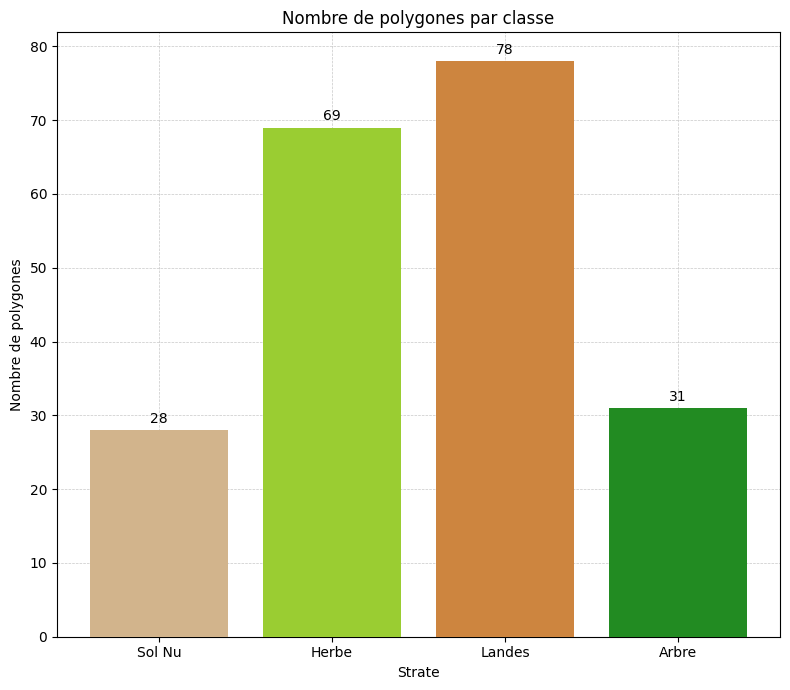

In [ ]:
# Chemins d’entrée / sortie
ts_path = "/home/onyxia/work/data/projet_eval"
in_vector = os.path.join(ts_path, "PI_strates_pyrenees_32630.shp")
ref_image = os.path.join(ts_path, "pyrenees_23-24_B02.tif")
samples_raster = "/home/onyxia/work/results/samples_raster.tif"

# Dossier pour enregistrer les figures
dir_fig = "/home/onyxia/work/results/figure"
os.makedirs(dir_fig, exist_ok=True)

# Lecture du shapefile d’échantillons
sample_data = gpd.read_file(in_vector)

# Nombre de polygones par strate
counts_label = sample_data.groupby("strate").size()

# Styles d’affichage
colors = ["tan", "yellowgreen", "peru", "forestgreen"]
names = {1: "Sol Nu", 2: "Herbe", 3: "Landes", 4: "Arbre"}

# Graphique : nb de polygones par classe 
fig, ax = plt.subplots(figsize=(8, 7))
bars = ax.bar(counts_label.index.astype(int), counts_label.values, color=colors, zorder=3)

ax.set_xticks(counts_label.index.astype(int))
ax.set_xticklabels([names.get(i, str(i)) for i in counts_label.index.astype(int)])

# Affichage des valeurs sur les barres
for bar in bars:
    ax.annotate(f"{int(bar.get_height())}",
                xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                xytext=(0, 3), textcoords="offset points",
                ha="center", va="bottom", zorder=4)

ax.set_title("Nombre de polygones par classe")
ax.set_xlabel("Strate")
ax.set_ylabel("Nombre de polygones")
ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7, zorder=0)

plt.tight_layout()
plt.show()
fig.savefig(os.path.join(dir_fig, "diag_baton_nb_poly_by_class.png"), dpi=300, bbox_inches="tight")

### Répartition des polygones d’apprentissage par strate

Ce graphique montre la distribution des polygones utilisés pour l’apprentissage, regroupés par classe de strate.

* **Lecture du résultat :** Les classes *Herbe* et *Landes* sont les plus représentées en nombre de polygones, tandis que *Sol nu* et *Arbre* disposent de moins d’échantillons.
* **Interprétation :** La base d’apprentissage présente donc un léger déséquilibre entre classes, ce qui peut influencer l’entraînement du modèle (classes majoritaires mieux apprises que les classes minoritaires).

**Diagramme de flux :**
![Flux de traitement pour générer l'histogramme de répartition des polygones par classe](/home/onyxia/work/projet_telea_MARTIN_AXEL/img/Diagramme_nb_polygone_classe.png)

##### **Nombre de pixel par classe :**

gdal_rasterize -at -a strate -tr 10.0 10.0 -te 684590.0 4744830.0 705620.0 4761380.0 -a_nodata 0 -ot Int32 -of GTiff "/home/onyxia/work/data/projet_eval/PI_strates_pyrenees_32630.shp" "/home/onyxia/work/results/samples_raster.tif"
0...10...20...30...40...50...60...70...80...90...100 - done.


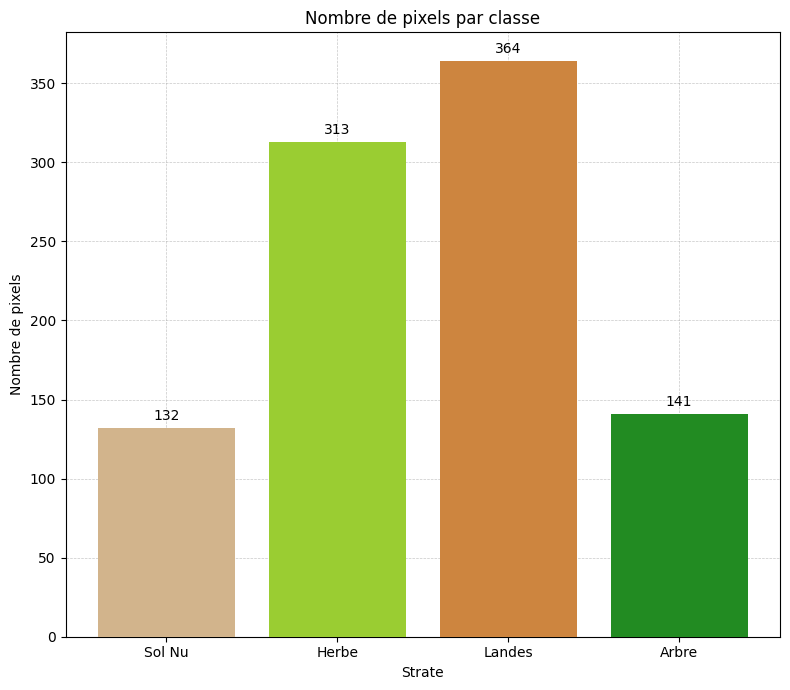

In [ ]:
strat = "strate"

# Rasterisation du shapefile (champ "strate") sur la grille de ref_image
my.rasterisation(in_vector, ref_image, samples_raster, strat, dtype="Int32")

# Lecture du raster des strates 
arr3d = rw.load_img_as_array(samples_raster, verbose=False)
arr = arr3d[:, :, 0]

# Comptage des pixels par classe 
vals = arr[arr != 0]
values, counts = np.unique(vals, return_counts=True)


# Graphique : nb de pixels par classe 
fig, ax = plt.subplots(figsize=(8, 7))
bars = ax.bar(values.astype(int), counts, color=colors[:len(values)], zorder=3)

ax.set_xticks(values.astype(int))
ax.set_xticklabels([names.get(v, str(v)) for v in values.astype(int)])

# Affichage des valeurs sur les barres
for bar in bars:
    ax.annotate(f"{int(bar.get_height())}",
                xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                xytext=(0, max(counts) * 0.01), textcoords="offset points",
                ha="center", va="bottom", zorder=4)

ax.set_title("Nombre de pixels par classe")
ax.set_xlabel("Strate")
ax.set_ylabel("Nombre de pixels")
ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7, zorder=0)

plt.tight_layout()
plt.show()
fig.savefig(os.path.join(dir_fig, "diag_baton_nb_pix_by_class.png"), dpi=300, bbox_inches="tight")

### Répartition des pixels après rasterisation

Ce graphique présente la distribution des pixels issus de la rasterisation des polygones.

* **Principe :** Le comptage est réalisé à partir du raster de strates obtenu après rasterisation.
* **Paramètre clé :** Le paramètre `all_touched=True` est utilisée lors de la rasterisation. Tous les pixels touchant un polygone, y compris ceux situés en bordure, sont affectés à la classe correspondante. Ce choix permet de mieux représenter l’emprise réelle des polygones, mais augmente le nombre de pixels comptabilisés.
* **Lecture du résultat :** La classe *Landes* domine en nombre de pixels, suivie par *Herbe*. Les classes *Sol nu* et *Arbre* sont moins représentées.
* **Interprétation :** La répartition en pixels ne reflète pas strictement celle des polygones, en raison des différences de surface entre les objets et de l’utilisation de `all_touched=True`, qui accentue l’influence des contours.

**Diagramme de flux :**
![Flux de traitement pour générer l'histogramme de répartition des pixels par classe](/home/onyxia/work/projet_telea_MARTIN_AXEL/img/Diagramme_nb_pixel_classe.png)

#### **4.2.2 Phénologie des strates, mise en évidence des landes**

#### **Création du raster d'ARI**

In [3]:
# ------------------------------------------------------------
# Calcul de l’indice ARI (série temporelle) à partir des bandes B03 et B05
# ------------------------------------------------------------

# Correspondance entre types numpy et types GDAL
data_type_match = {
    'uint8': gdal.GDT_Byte,
    'uint16': gdal.GDT_UInt16,
    'uint32': gdal.GDT_UInt32,
    'int16': gdal.GDT_Int16,
    'int32': gdal.GDT_Int32,
    'float32': gdal.GDT_Float32,
    'float64': gdal.GDT_Float64
}

# --- Définition des chemins ---
dirname = '/home/onyxia/work/data/projet_eval'
out_dirname = '/home/onyxia/work/results'

dir_B3 = os.path.join(dirname, 'pyrenees_23-24_B03.tif')
dir_B5 = os.path.join(dirname, 'pyrenees_23-24_B05.tif')
out_ari_filename = os.path.join(out_dirname, 'ARI_serie_temp.tif')

# --- Lecture des bandes spectrales ---
data_set_B3 = rw.open_image(dir_B3)
img_B3 = rw.load_img_as_array(dir_B3)

data_set_B5 = rw.open_image(dir_B5)
img_B5 = rw.load_img_as_array(dir_B5)

# --- Conversion en float pour le calcul des indices ---
B3 = img_B3[:, :, :].astype('float32')
B5 = img_B5[:, :, :].astype('float32')

# --- Calcul de l’indice ARI (série temporelle) ---
ari = my.compute_ari_timeseries(B3, B5)

# --- Écriture du raster ARI ---
rw.write_image(
    out_ari_filename,
    ari,
    data_set=data_set_B5,
    gdal_dtype=data_type_match['float32'],
    projection=None
)

# --- Définition de la valeur NoData ---
ds = gdal.Open(out_ari_filename, gdal.GA_Update)
band = ds.GetRasterBand(1)
band.SetNoDataValue(-9999)
band.FlushCache()
ds = None

ARI stats: min = -0.969209 max = 0.880237 mean = 0.110966586


#### **Création du graphique de série temporelle moyenne d’ARI de chaque strate**

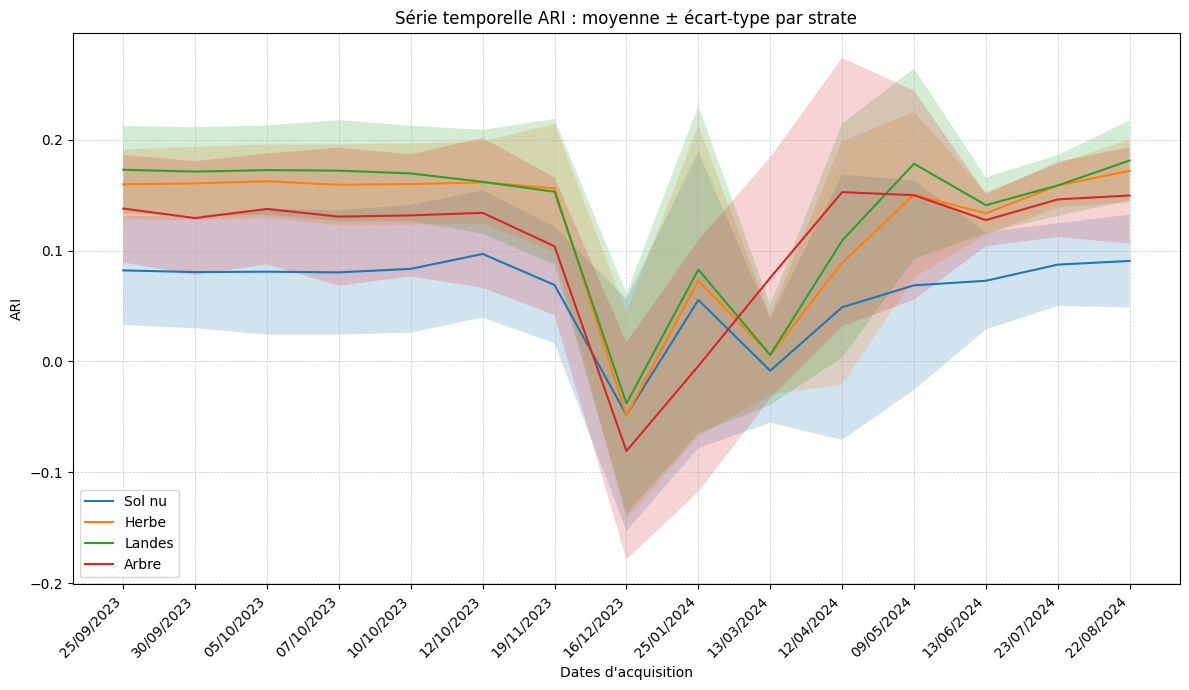

In [9]:
# ------------------------------------------------------------
# Analyse des séries temporelles de l’indice ARI par strate
# ------------------------------------------------------------

# Définition des dates d’acquisition 
dates = [
    "25/09/2023", "30/09/2023", "05/10/2023", "07/10/2023", "10/10/2023",
    "12/10/2023", "19/11/2023", "16/12/2023", "25/01/2024", "13/03/2024",
    "12/04/2024", "09/05/2024", "13/06/2024", "23/07/2024", "22/08/2024"
]

# --- Extraction des pixels ARI par strate ---
dict_X, dict_Y, dict_t = cla.get_samples_from_roi(
    out_ari_filename,
    samples_raster,
    output_fmt="by_label"
)

# Dictionnaire de correspondance entre codes et noms des strates
names = {1: "Sol nu", 2: "Herbe", 3: "Landes", 4: "Arbre"}

# --- Initialisation de la figure ---
fig, ax = plt.subplots(figsize=(12, 7))

# Nombre de dates (bandes temporelles)
n_dates = dict_X[list(dict_X.keys())[0]].shape[1]
x = np.arange(n_dates)

# --- Calcul et tracé des statistiques par strate ---
# Pour chaque strate, la moyenne et l’écart-type de l’ARI sont calculés à chaque date afin de représenter la dynamique temporelle.
for lab in sorted(dict_X.keys()):
    X = dict_X[lab]

    # Remplacement des valeurs NoData par NaN pour éviter leur prise en compte
    X = np.where(X == -9999, np.nan, X)

    mean = np.nanmean(X, axis=0)
    std  = np.nanstd(X, axis=0)

    ax.plot(x, mean, label=names.get(lab, f"Strate {lab}"))
    ax.fill_between(x, mean - std, mean + std, alpha=0.2)

# --- Mise en forme du graphique ---
ax.set_xlabel("Dates d'acquisition")
ax.set_ylabel("ARI")
ax.set_title("Série temporelle ARI : moyenne ± écart-type par strate")
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
ax.legend()

# Remplacement des indices temporels par les dates réelles
ax.set_xticks(x)
ax.set_xticklabels(dates, rotation=45, ha='right')

# Affichage et sauvegarde de la figure
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(dir_fig, "ARI_series.png"), dpi=300, bbox_inches='tight')


### **4.3 Production d’une carte de strates à l’échelle du pixel**

#### **4.3.2 Stratégie de validation (GridSearchCV)** ###

Stackage des images 

In [ ]:
# ------------------------------------------------------------
# Construction du stack multi-bandes fusionné (Sentinel-2 + ARI)
# ------------------------------------------------------------

# Liste des bandes spectrales Sentinel-2 utilisées
bands = [
    "B02",
    "B03",
    "B04",
    "B05",
    "B06",
    "B07",
    "B08",
    "B8A",
    "B11",
    "B12"
]

# --- Construction du stack fusionné via la fonction build_multiband_stack_with_ari ---
stack_fused, ds_ref = my.build_multiband_stack_with_ari(
    folder=ts_path,
    prefix="pyrenees_23-24",
    bands=bands,
    ari_path=out_ari_filename
)

# --- Écriture du raster fusionné ---
out_fused = "/home/onyxia/work/results/py_ari_stack.tif"
rw.write_image(
    out_fused,
    stack_fused,
    data_set=ds_ref,
    nb_band=stack_fused.shape[2]
)

Rasterisation du fichier d'échantillon via le champs "id"

In [6]:
samples_raster_id = '/home/onyxia/work/results/samples_raster_id.tif'
my.rasterisation(in_vector, ref_image, samples_raster_id, "id", dtype="Int32")

gdal_rasterize -at -a id -tr 10.0 10.0 -te 684590.0 4744830.0 705620.0 4761380.0 -a_nodata 0 -ot Int32 -of GTiff "/home/onyxia/work/data/projet_eval/PI_strates_pyrenees_32630.shp" "/home/onyxia/work/results/samples_raster_id.tif"
0...10...20...30...40...50...60...70...80...90...100 - done.


0

In [ ]:
# ------------------------------------------------------------
# Extraction des échantillons pour l’apprentissage supervisé
# ------------------------------------------------------------

# Extraction des variables explicatives (X), des classes (Y) et des positions des pixels à partir du stack fusionné
X, Y, t = cla.get_samples_from_roi(out_fused, samples_raster)

# Extraction des identifiants de groupes 
_, groups, _ = cla.get_samples_from_roi(out_fused, samples_raster_id)

# Mise en forme des vecteurs cibles et des groupes
Y = np.asarray(Y).reshape(-1)
groups = np.asarray(groups).reshape(-1)


# ------------------------------------------------------------
# Définition du modèle et de la grille d’hyperparamètres
# ------------------------------------------------------------

# Initialisation du classifieur Random Forest
rf = RF(random_state=0, n_jobs=-1)

# Grille d’hyperparamètres
param_grid = {
    "n_estimators": [150, 300],
    "max_depth": [None, 20],
    "max_features": ["sqrt"],
    "min_samples_leaf": [1, 5],
}


# ------------------------------------------------------------
# Validation croisée stratifiée avec contrainte de groupes
# ------------------------------------------------------------

cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=0)

# Recherche des meilleurs hyperparamètres par GridSearch
grid = GridSearchCV(
    rf,
    param_grid,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1
)

# Entraînement du modèle avec prise en compte des groupes
grid.fit(X, Y, groups=groups)

# Affichage des meilleurs paramètres et de la performance associée
print(grid.best_params_)

# Récupération du meilleur modèle entraîné
best_model = grid.best_estimator_

{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 150}


OA = 0.830 ± 0.084


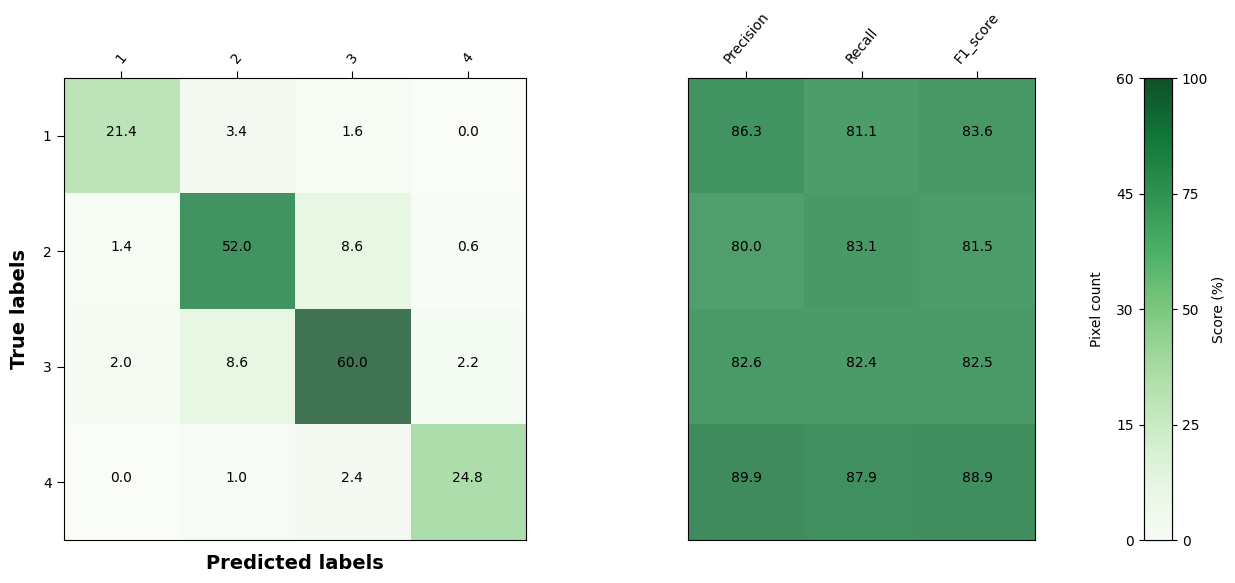

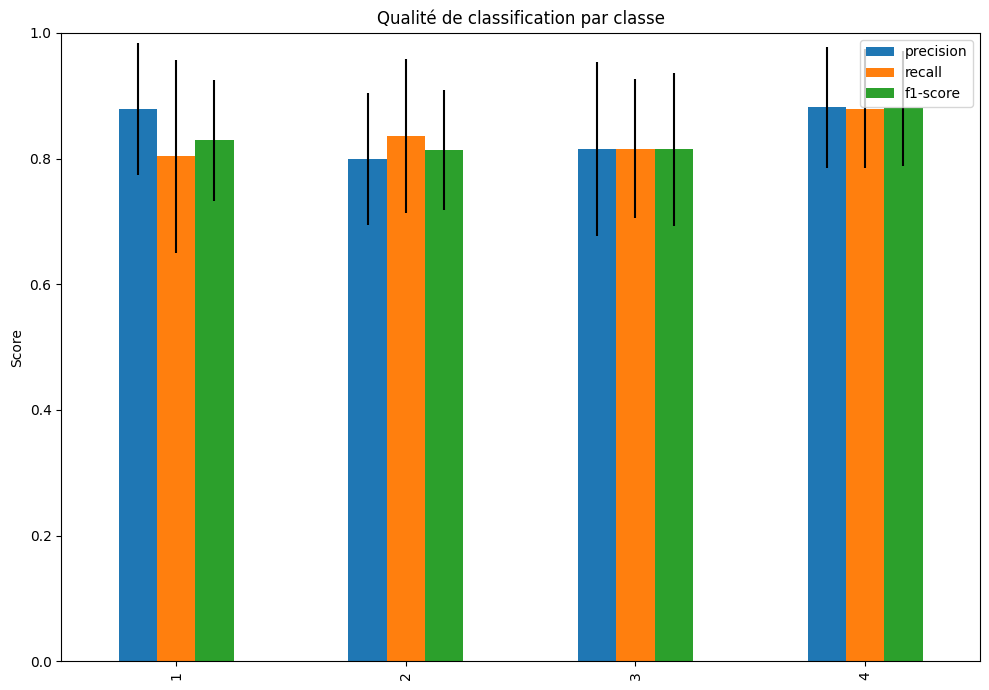

In [14]:
# ------------------------------------------------------------
# Évaluation du modèle par validation croisée groupée
# ------------------------------------------------------------

list_cm = []          # matrices de confusion
list_accuracy = []    # accuracies globales
list_report = []      # rapports de classification par classe


# ------------------------------------------------------------
# Boucle sur les folds de la validation croisée
# ------------------------------------------------------------

for train_idx, test_idx in cv.split(X, Y, groups=groups):

    # Séparation apprentissage / test
    X_train, X_test = X[train_idx], X[test_idx]
    Y_train, Y_test = Y[train_idx], Y[test_idx]

    # Clonage du meilleur modèle trouvé par GridSearch
    clf = clone(best_model)
    clf.fit(X_train, Y_train)

    # Prédiction sur le jeu de test
    Y_pred = clf.predict(X_test)

    # Calcul et stockage de la matrice de confusion
    list_cm.append(
        confusion_matrix(Y_test, Y_pred, labels=np.unique(Y))
    )

    # Calcul et stockage de l’accuracy globale
    list_accuracy.append(
        accuracy_score(Y_test, Y_pred)
    )

    # Calcul et stockage des métriques par classe
    rep = classification_report(
        Y_test,
        Y_pred,
        labels=np.unique(Y),
        output_dict=True,
        zero_division=0
    )
    list_report.append(pd.DataFrame(rep).T)


# ------------------------------------------------------------
# Agrégation des résultats sur l’ensemble des folds
# ------------------------------------------------------------

# Moyenne de la matrice de confusion
array_cm = np.array(list_cm)
mean_cm = array_cm.mean(axis=0)

# Moyenne et écart-type de l’accuracy globale
array_accuracy = np.array(list_accuracy)
mean_accuracy = array_accuracy.mean()
std_accuracy = array_accuracy.std()

# Moyenne et écart-type des métriques par classe
all_reports = pd.concat(list_report, keys=range(len(list_report)))
mean_df_report = all_reports.groupby(level=1).mean()
std_df_report  = all_reports.groupby(level=1).std()

print(f"OA = {mean_accuracy:.3f} ± {std_accuracy:.3f}")


# ------------------------------------------------------------
# Visualisation des performances
# ------------------------------------------------------------

# Affichage de la matrice de confusion moyenne
plots.plot_cm(mean_cm, labels=list(np.unique(Y)))
plt.show()

# Barplot des métriques par classe (precision / recall / f1-score)
class_labels = [str(l) for l in np.unique(Y)]
mean_cls = mean_df_report.loc[class_labels, ["precision", "recall", "f1-score"]]
std_cls  = std_df_report.loc[class_labels,  ["precision", "recall", "f1-score"]]

ax = mean_cls.plot.bar(yerr=std_cls, figsize=(10, 7), zorder=2)
ax.set_ylim(0, 1)
ax.set_title("Qualité de classification par classe")
ax.set_ylabel("Score")
plt.tight_layout()
plt.show()

#### **4.3.3 Contribution des variables**

n_series temporelles = 11


,feature,importance
0,B03_13/03/2024,0.026719
1,B03_25/09/2023,0.021329
2,B04_13/03/2024,0.020554
3,B04_10/10/2023,0.019393
4,B03_22/08/2024,0.019228
5,B04_30/09/2023,0.018405
6,B03_30/09/2023,0.017816
7,B02_25/09/2023,0.017338
8,ARI_25/09/2023,0.016870
9,B02_13/03/2024,0.016869


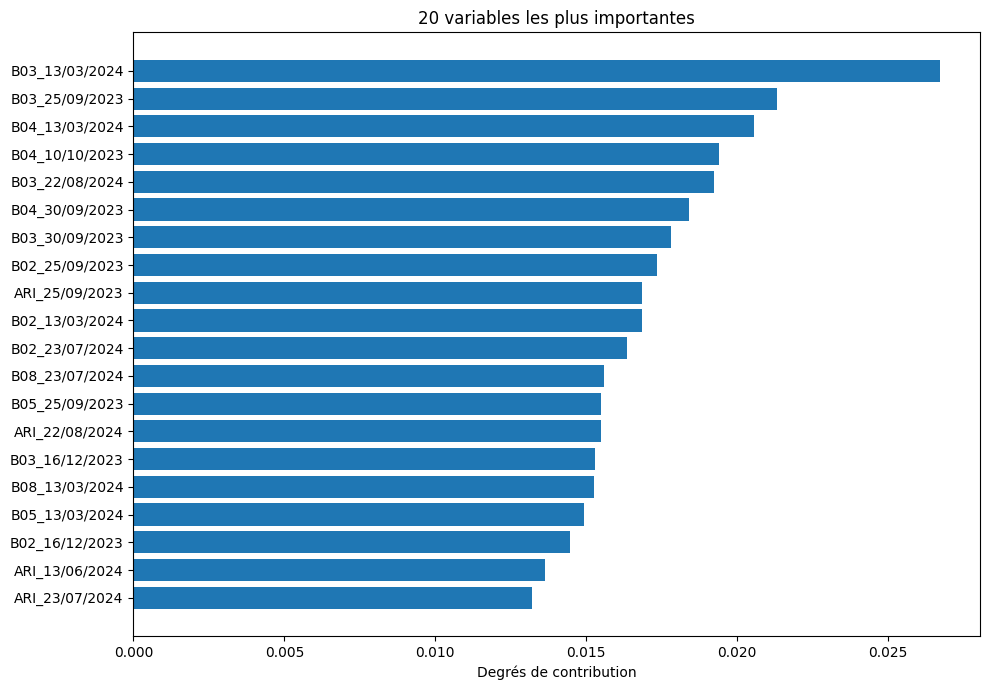

In [ ]:
# ------------------------------------------------------------
# Analyse de l’importance des variables du modèle Random Forest
# ------------------------------------------------------------

# Récupération des importances calculées par le Random Forest
importances = best_model.feature_importances_

# Nombre total de variables utilisées par le modèle
n_features = importances.shape[0]


# ------------------------------------------------------------
# Définition des dates de la série temporelle
# ------------------------------------------------------------

# Dates d’acquisition des images Sentinel-2 (ordre chronologique)
n_dates = len(dates)


# ------------------------------------------------------------
# Reconstruction du nom des variables (bandes × dates)
# ------------------------------------------------------------

# Vérification que le nombre total de variables est cohérent avec une structure multi-temporelle
if n_features % n_dates == 0:
    n_series = n_features // n_dates
    print("n_series temporelles =", n_series)

    if n_series == len(bands) + 1:
        series_names = bands + ["ARI"]
    else:
        series_names = [f"S{i+1}" for i in range(n_series)]

    # Création des noms des variables sous la forme :
    feature_names = []
    for s in series_names:
        for d in dates:
            feature_names.append(f"{s}_{d}")


# Sécurité : vérification de la cohérence
assert len(feature_names) == n_features


# ------------------------------------------------------------
# Création du tableau des contributions des variables
# ------------------------------------------------------------

# Association du nom des variables et de leur importance
df_imp = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
})

# Tri décroissant selon l’importance
df_imp = df_imp.sort_values("importance", ascending=False).reset_index(drop=True)

# Affichage des variables les plus contributives
display(df_imp.head(10))


# ------------------------------------------------------------
# Visualisation des variables les plus importantes
# ------------------------------------------------------------

# Sélection des 20 variables les plus discriminantes
top_n = 20
df_top = df_imp.head(top_n)

# Barplot horizontal 
plt.figure(figsize=(10, 7))
plt.barh(df_top["feature"][::-1], df_top["importance"][::-1])
plt.xlabel("Degrés de contribution")
plt.title(f"{top_n} variables les plus importantes")
plt.tight_layout()
plt.show()

#### **4.3.4 Production de la carte finale**

/home/onyxia/work/libsigma/classification.py:101: RuntimeWarning: invalid value encountered in cast
  Y = ROI[t].reshape((t[0].shape[0], 1)).astype('int32')


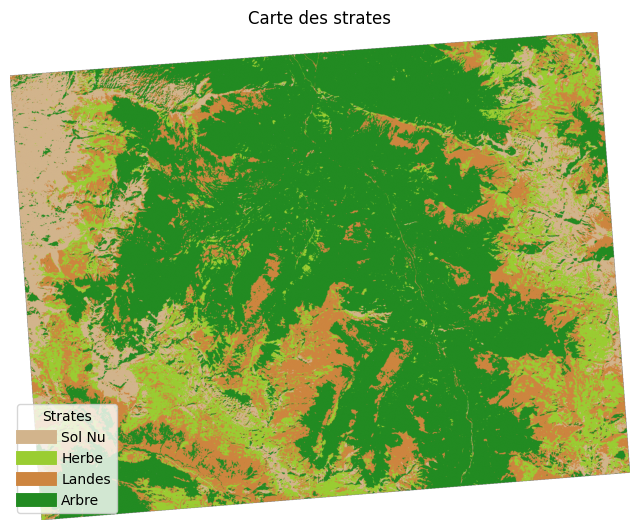

In [28]:
# ------------------------------------------------------------
# Application du modèle sur l’image complète et génération de la carte de strates
# ------------------------------------------------------------

out_classif = "/home/onyxia/work/results/carte_strates.tif"

# Extraction des pixels + prédiction
X_img, _, t_img = cla.get_samples_from_roi(out_fused, out_fused)
Y_pred = best_model.predict(X_img)

# Reconstruction de la carte
ds = rw.open_image(ref_image)
nb_row, nb_col, _ = rw.get_image_dimension(ds)

ref_data = ds.GetRasterBand(1).ReadAsArray()  # pour le masque NoData/NaN

img = np.zeros((nb_row, nb_col, 1), dtype="uint8")
img[t_img[0], t_img[1], 0] = Y_pred

# Masque : zones sans donnée dans l’image de référence
img[np.isnan(ref_data), 0] = 0

# Écriture
rw.write_image(out_classif, img, data_set=ds, gdal_dtype=data_type_match["uint8"], nb_band=1)

# Fix NoData à 0
ds_out = gdal.Open(out_classif, gdal.GA_Update)
ds_out.GetRasterBand(1).SetNoDataValue(0)
ds_out = None
ds = None

# ------------------------------------------------------------
# Affichage de la carte des strates dans le notebook
# ------------------------------------------------------------

# Lecture du raster classifié 
arr3d = rw.load_img_as_array(out_classif, verbose=False)
carte = arr3d[:, :, 0].astype(np.uint8)

# Définition des bornes pour les classes 
bounds = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5]
norm = BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(8, 8))
plt.imshow(img[:, :, 0], cmap=cmap, norm=norm)

for val, col in zip([1, 2, 3, 4], colors):
    plt.plot([], [], color=col, label=names[val], linewidth=10)

plt.legend(title="Strates", loc="lower left")
plt.title("Carte des strates")
plt.axis("off")
plt.show()

#### **4.3.5 Analyse des résultats**